![](Rydiqule_Logo_Transparent_300.png)

# RF heterodyne example

For a more thorough introduction to the core functionality of `rydiqule`, it may be helpful to look at the `Introduction_to_Rydiqule.ipynb` notebook before this one.

This notebook demonstrates two-tone detection using a Rydberg sensor in the time domain.  An RF local oscillator (LO) and signal (sig) are imposed on the Rydberg sensor.  This is useful for RF phase detection, and can be used to linearize the detection, as shown below.  The main results of this example are:

1. we show that the time solver and steady-state solver approximately agree.  
2. we plot an example of a time response due to RF heterodyne.  
3. we find the optimum detuning of the Rydberg laser for RF heterodyne, for a given value of LO power.  
4. we plot the linear dynamic of the RF heterodyning scheme, and show that it is limited by the LO power on the high end.  The result is limited by the solver tolerance on the low end.  

In [2]:
import datetime

##***LAST UPDATE***##
now = datetime.datetime.now()
print(now)

2023-10-10 16:29:39.706585


## Imports

In [3]:
import numpy as np
import rydiqule as rq
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
%load_ext autoreload
%autoreload 2

## Comparing the steady-state and time solver results

This example uses a `Cell` object, which inherits `Sensor`. The `Cell`'s purpose is to attach the bare pyhiscs calculations of a `Sensor` to a real physical atom (Rubidium-85) by default. This allows for specification of quantum numbers for states, meaning `rydiqule` can calculate things like transition frequencies (using ARC Rydberg) without needing to specify them in the object creation. The details will be discussed further down.

NOTE:  The time solver runs more slowly for large transition frequencies, since it makes no rotating wave approximation.  Therefore, it is advisable to debug calculations using a transition with a low frequency (ie, very large N).  Once calculations are debugged and running well, they can be re-run with the appropriate n-level.  Further, ARC calculates dipole moments for the chosen transition.  For large n, this calculation is slow, due to the large amount of structure in the atomic wavefunction.  However, ARC caches the results, so it only runs slowly the first time. It will likely take several minutes to calculate the add_states function, the first time, but then will run quickly.

### The steady-state `Cell`

In [5]:
#states in cell are labeled by [n, l, j, m_j]
#A base sensor object does not support specification of quantum numbers for each level
rydberg_target_state = [150, 2, 2.5, 0.5]  
rydberg_excited_state = [149, 3, 3.5, 0.5]

atom = "Rb85"
RbSensor_ss = rq.Cell(atom, *rq.D2_states(atom), rydberg_target_state, rydberg_excited_state, 
                      gamma_transit=2*np.pi*1, cell_length = 0.01)

#### Define Transitions
Transitions are defined as dictionaries in a `Cell` in the same way as they are in a bas `Sensor`. For the steady-state case, nothing changes. For this example, will observer the response of the system over a series of 200 blue laser detunings.

In [6]:
rf_rabi = 25 #Mrad/s
n_det_ss = 200
detunings_ss = np.linspace(-150, 150, n_det_ss)

red_laser = {'states':(0,1), 'rabi_frequency':2*np.pi*0.6, 'detuning':0}
blue_laser = {'states':(1,2), 'rabi_frequency':2*np.pi*1.0, 'detuning':detunings_ss}
local_oscillator_ss = {'states':(2,3), 'rabi_frequency':rf_rabi, 'detuning':0}

RbSensor_ss.add_couplings(red_laser, blue_laser, local_oscillator_ss)

#### Solve the steady state system
We solve a `Cell` in exaclty the same way we solve a `Sensor` object.

In [7]:
ss_solution = rq.solve_steady_state(RbSensor_ss)
print(ss_solution.rho.shape)

(200, 15)


### The time solver `Cell`
We want to use the same decoherence values

In [8]:
rydberg_target_state = [150, 2, 2.5, 0.5]  
rydberg_excited_state = [149, 3, 3.5, 0.5]

RbSensor_time = rq.Cell(atom, *rq.D2_states(atom), rydberg_target_state, rydberg_excited_state, 
                        gamma_transit=2*np.pi*1, cell_length = 0.01)

#### Define Couplings

In [9]:
[n,l,j,m] = RbSensor_ss.states_list()[2]
[n2, l2, j2, m2]  = RbSensor_ss.states_list()[3]
rf_freq = RbSensor_ss.atom.getTransitionFrequency(n2,l2,j2,n,l,j)*1E-6
def rf_carrier(t):
    return np.cos(2*np.pi*rf_freq*t)#extra factor of 2 to account for no RWA. 

In [10]:
n_det = 20
detunings = np.linspace(-75, 75, n_det)

red_laser = {'states':(0,1), 'rabi_frequency':2*np.pi*0.6, 'detuning':0}
blue_laser = {'states':(1,2), 'rabi_frequency':2*np.pi*1.0, 'detuning':detunings}
rf_transition = {'states':(2,3), 'rabi_frequency':rf_rabi, 'time_dependence': rf_carrier }

RbSensor_time.add_couplings(red_laser, blue_laser, rf_transition)

#### Defining the rf field
The `time_dependence` argument s expected to be a python function of a single variable (time in $\mu s$) that returns the field at that time. To match our steady state solution, which had a detuning of 0, we will explicitly define a single-tone field as a function of time that is resonant with our rf transition.

#### Solve in the time domain
Internally, the time solver will loop over all detuning values and output the full result. You can use the `verbose` flag to print its progress to `stdout`

In [11]:
%%time
end_time = 10 #microseconds
sample_num = 10

time_solution = rq.solve_time(RbSensor_time, end_time, sample_num, atol=1e-6, rtol=1e-6)

CPU times: total: 9.98 s
Wall time: 15.7 s


In [12]:
RbSensor_time.couplings.edges[2,3]

{'rabi_frequency': 25,
 'transition_frequency': 4138.025828450375,
 'phase': 0,
 'kvec': (0, 0, 0),
 'time_dependence': <function __main__.rf_carrier(t)>,
 'dipole_moment': 14533.336151288706,
 'label': '(2,3)'}

### Comparing results
Now, with results for both steady state and time simulations, we can compare them and see that they match. Note that because the time solution has an extra dimension, we only get the last (`[:,-1]`) element, since this is effectively the steady-state solution (assuming transient behavior has been damped out by 10 $\mu$s). Here we also use a function to get the transmission coefficient from the solution quickly by extracting the proper density matrix elements.

In [16]:
time_solution.get_transmission_coef().shape

(20, 10)

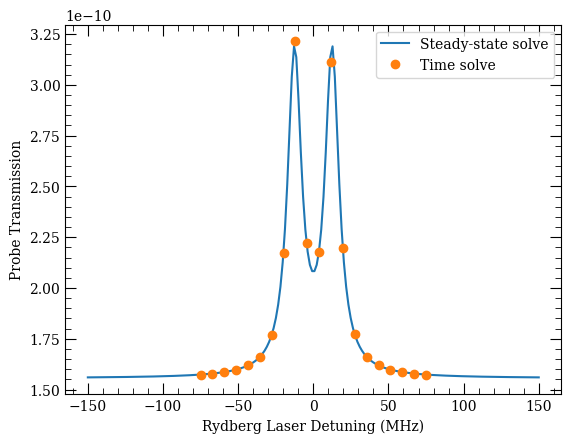

In [17]:
#Modify to include convenience functions and get physical parameters.

fig, ax = plt.subplots()
ax.plot(detunings_ss, ss_solution.get_transmission_coef(), label="Steady-state solve")
ax.plot(detunings, time_solution.get_transmission_coef()[:,-1], 'o', label="Time solve")
ax.set_xlabel("Rydberg Laser Detuning (MHz)")
ax.set_ylabel("Probe Transmission")
ax.legend();

## Observe a heterodyne beat between the Signal and LO.
The goal of this section is to see the beating behavior in time between the signal and rf local oscillator. This will help see exactly how to observe behavior in the time domain with rydiqule. It will look a lot like other time solves, but we will look at the solution in a different way.

### Define the RF LO and signal
Just like before, we need a function of time to input into the time solver. This time, instead of just an rf carrier signal, we will define a function that adds a local oscillator of frequency $\omega_0$ with an "incoming" rf signal of frequency $\omega_0+\delta$. We will also define the time function as the return of another function, which will allow us to make changes to the function quickly if we want to experiment a little. 

In [18]:
def sig_and_LO(omega_0, delta, beta):
    def fun(t):
        return np.sin(omega_0*t)+beta*np.sin((omega_0+delta)*t)
    return fun

In [19]:
omega_0 = 2*np.pi*rf_freq
delta = 5 
beta = 0.05

### The Sensor
We will use the same `RbSensor_time` sensor as before, but change the blue laser to be just a single value. This highlights an important aspect of `Sensor`. At present, it does not support multiple fields coupling the same pair of levels, but will override an old one with a new one when `add_coupling()` is called.

In [20]:
red_laser = {'states':(0,1), 'rabi_frequency':2*np.pi*0.6, 'detuning':0}
blue_laser = {'states':(1,2), 'rabi_frequency':6.0, 'detuning': 0}
rf_transition = {'states':(2,3), 'rabi_frequency':rf_rabi, 'time_dependence': sig_and_LO(omega_0, delta, beta )}
RbSensor_time.add_couplings(red_laser,blue_laser, rf_transition)

### Inital conditions
If the `init_cond` argument is not supplied to `rq.solve_time`, it will calculate the inital condition based on the steady-state solution of the supplied sensor **without** any of the time-dependant fields. Since we define our incoming field and LO in a single function, we will likely end up with a sizeable transient if we use this approach. This is now a great opportunity to demonstrate how to supply an inital condition manually. We calculate our inital condition using the solution to the **steady-state** sensor we defined above. Hopefully, this allows us to see the beat oscillation around the steady-state solution without a large transient from introducing our LO and rf field at the same time.

Solving is done the same way as before, this time solving for 250 points in 10 microseconds

In [21]:
RbSensor_ss.add_couplings(blue_laser)
sol_init = rq.solve_steady_state(RbSensor_ss)

sample_num=250
end_time = 10

time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num,  init_cond=sol_init.rho)

print(time_sol_beat.rho.shape)

(250, 15)


### Plotting the beat
We now use the `get_transmission_coef()` function again to extract the transmission from the `(250,15)`-shaped solution to get a 250 element array we can plot against time. We can see that the system quickly settles into the expected beat frequency of 1 MHZ

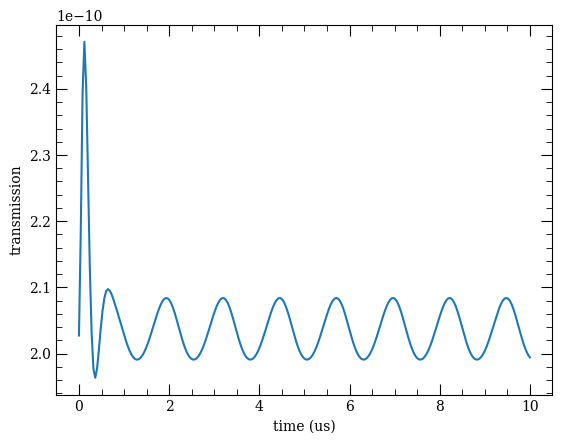

In [26]:
fig, ax = plt.subplots()
transmission = time_sol_beat.rho[:,3]
ax.plot(time_sol_beat.t, time_sol_beat.get_transmission_coef())
ax.set_xlabel("time (us)");
ax.set_ylabel('transmission');

We do have a bit of transient behavior at the start, but we can clearly see the beat expected bead frequency of 5Mrad/s $\approx$ 800kHz.

## RF Heterodyne in the Rotating Wave Approximation  
We move to a rotating frame by specifying an rf detuning, and writing the coupling in the complex rotating frame.  This transformation will greatly speed up the time integration.

In [27]:
def sig_LO_RWA(det, beta):
    def fun(t):
        return 1+beta*np.exp(1j*det*t)
    return fun

red_laser = {'states':(0,1), 'rabi_frequency':2*np.pi*0.6, 'detuning':0}
blue_laser = {'states':(1,2), 'rabi_frequency':6.0, 'detuning': 0}
rf_transition = {'states':(2,3), 'rabi_frequency':rf_rabi, 'detuning':0, 'time_dependence': sig_LO_RWA(delta, beta )}
RbSensor_time.add_couplings(red_laser, blue_laser, rf_transition)

sol_init = rq.solve_steady_state(RbSensor_ss)

In [28]:
sample_num=250
end_time = 10
time_sol_beat = rq.solve_time(RbSensor_time, end_time, sample_num)

c:\users\naqsl\documents\github\rydiqule\src\rydiqule\sensor_solution.py:223: UserWarning: At least one solution has optical depth greater than 1. Integrated results are likely invalid.
  warnings.warn(('At least one solution has optical depth '


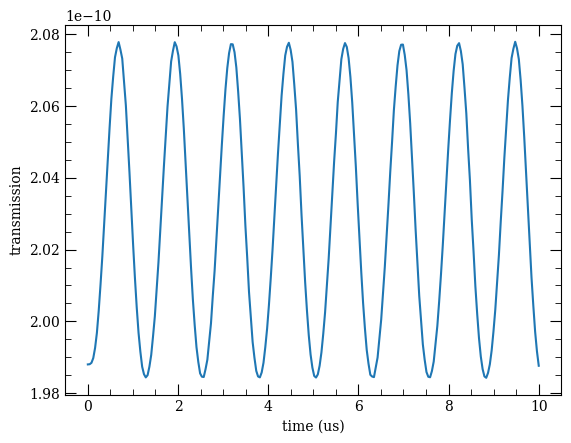

In [29]:
fig, ax = plt.subplots()
ax.plot(time_sol_beat.t, time_sol_beat.get_transmission_coef())
ax.set_xlabel("time (us)");
ax.set_ylabel('transmission');


## Find the optimum laser detuning with LO
We again use the same sensor to look at the sensitivity of the sensor as a function of blue laser detuning. 

### Set up and solve `Sensor`

In [31]:
num_dets = 75
detuning_list = np.linspace(-40,40,num_dets)
pk_to_pk_result = np.zeros(num_dets)
rf = sig_and_LO(2*np.pi*rf_freq, 5, 0.01)

sample_num = 300
end_time = 3
blue_laser = {'states':(1,2), 'rabi_frequency':6.0, 'detuning': detuning_list}
rf_transition = {'states':(2,3), 'rabi_frequency':rf_rabi, 'time_dependence': sig_and_LO(rf_freq*2*np.pi, 2*np.pi, .05 )}
RbSensor_time.add_couplings(blue_laser, rf_transition) #this replaces the old coupling

time_sol = rq.solve_time(RbSensor_time, end_time, sample_num)

In [32]:
susceptibility = time_sol.rho[:,100:,3]
print(susceptibility.shape)
ptp_result = np.ptp(susceptibility, axis=-1)

(75, 200)


### Plotting responsivity versus LO detuning

Text(0.5, 0, 'Rydberg laser detuning (Mrad/s)')

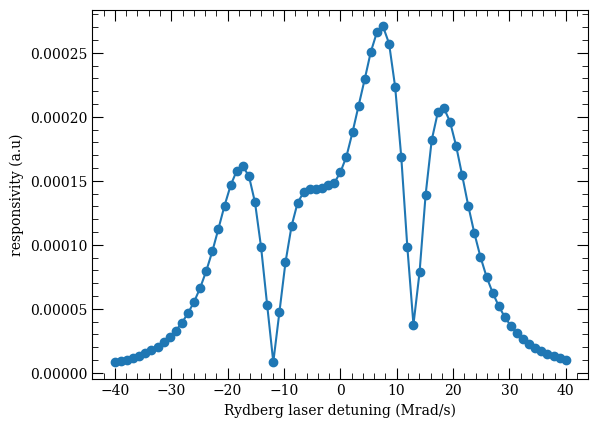

In [33]:
fig, ax = plt.subplots()
ax.plot(detuning_list, ptp_result,'o-')
ax.set_ylabel("responsivity (a.u)")
ax.set_xlabel("Rydberg laser detuning (Mrad/s)")

This plot shows that, for maximum responsivity, the Rydberg (or probe) laser must be tuned to the side of an Autler-Townes peak, for maximum sensitivity

## Test the Linear Dynamic Range
Example testing the linear dynamic range in Heterodyne

### Setting the laser parameters

We will set the blue laser detuning to -8 MRad/s, which was roughly the optimal value from the plot above

In [34]:
blue_laser = {'states':(1,2), 'rabi_frequency':6.0, 'detuning': -8}
RbSensor_time.add_couplings(blue_laser)

### Solve parameters
With the detuning set, we can set up everything we need for our scan, namely the solver parameters and list of amplitudes.

In [36]:
num_Amps = 50
amp_list = np.logspace(-6,0.2,num_Amps)
sample_num = 300
end_time = 3



### Running the loop
Now all that is left is get the value we want at each amplitude using a good old python `for` loop. This could be done with something like a `map()` function depending on your comfort level with python, but we will be explicit here.

In [37]:
pk_to_pk_result = np.zeros(num_Amps)

for idx, amp in enumerate(tqdm(amp_list)):
    #define and solve for rf input
    
    rf = sig_and_LO(2*np.pi*rf_freq, 5, amp)
    rf_transition = {'states':(2,3), 'rabi_frequency':rf_rabi, 'detuning':1, 'time_dependence': sig_LO_RWA(1, amp)}
    RbSensor_time.add_couplings(rf_transition)
    time_sol = rq.solve_time(RbSensor_time, end_time, sample_num,  init_cond=sol_init.rho, atol=1e-7, rtol=1e-7)
    
    #calculate responsivity
    pk_to_pk_signal = np.ptp(time_sol.rho[100:,3])
    pk_to_pk_result[idx] = pk_to_pk_signal
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.75it/s]


### Plotting the dynamic range

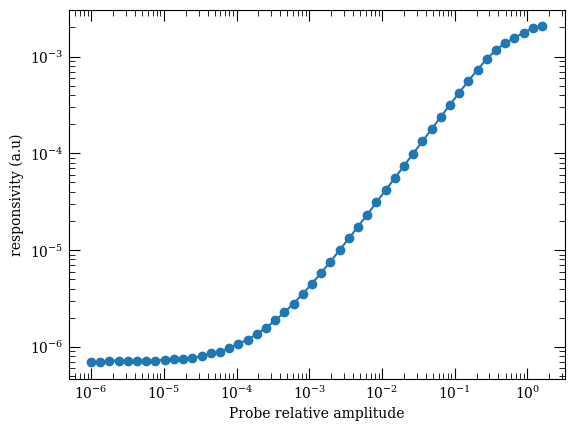

In [38]:
fig, ax = plt.subplots()
ax.plot(amp_list, pk_to_pk_result,'o-')
ax.set_ylabel("responsivity (a.u)")
ax.set_xlabel("Probe relative amplitude")
ax.set_xscale('log')
ax.set_yscale('log')

The authors recognize financial support from the US Army and Defense Advanced Research Projects Agency (DARPA). Rydiqule has been approved for unlimited public release by DEVCOM Army Research Laboratory and DARPA.  This software is released under the xx licence through the University of Maryland Quantum Technology Center.  The views, opinions and/or findings expressed here are those of the authors and should not be interpreted as representing the official views or policies of the Department of Defense or the U.S. Government.